Code used for creating Fig. 4 in [New Journal of Physics 20, 043034 (2018)](https://dx.doi.org/10.1088/1367-2630/aaba02)
---
Runs an Otto cycle between two baths of harmonic oscillators, computing the work output after every interaction, the heat loss at every cycle, and the efficiency of the machine after every cycle. Variables with a C or H at the end refer to the parameters used for the hot bath (H) and the cold bath (C).
 
authors:     Alejandro Pozas-Kerstjens, Karen V. Hovhanissyan,
             Eric G. Brown

requires:    NumPy, SciPy, Matplotlib

last update: Sep, 2017

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy.linalg

from functions import *

Choice of parameters
----

In [2]:
# WM frequencies
OmC       = 1
OmH       = 2

# WM coupling strengths with the baths
gammaC    = 0.1
gammaH    = gammaC

# Baths' temperatures
TC        = 0.5
TH        = 4

# Number of modes in the baths
NC        = 300
NH        = NC

# Baths modes' frequencies
freqsC    = OmC * np.ones(NC)
freqsH    = OmH * np.ones(NH)

# Baths inner couplings (nearest-neighbors)
alphaC    = 0.1
alphaH    = alphaC
alphasC   = alphaC * np.ones(NC - 1)
alphasH   = alphaH * np.ones(NH - 1)

# Number of cycles we run for
Ncycle    = 200

# Time of interaction with one bath; must be at least 2*delta
tf        = 100

# Ramp-up time; want it to be large compared to inverse WM's 
# frequency so as to remain approximately adiabatic
delta     = 0.1 * tf

# Time steps for numerical integrations; must be very small
# compared to inverse WM's frequency
dt        = 0.01

# Set bath modes with which the WM interacts
interactC = 1
interactH = NC + interactC

Computations
----

In [3]:
# Baths free Hamiltonians
FfreeC  = FreeRing(NC, freqsC, alphasC)
FfreeH  = FreeRing(NH, freqsH, alphasH)

# Initial detector state
# We start by interacting with the hot bath, assuming that
# the WM is in a state thermal with the cold bath
sigDetI = np.identity(2) * (np.exp(OmC / TC) + 1) / (np.exp(OmC / TC) - 1)

# Initialize global state of the system (detector plus two baths)
sigI    = scipy.linalg.block_diag(sigDetI, Initialize(NC, TC, FfreeC), Initialize(NH, TH, FfreeH))

# Switching function
steps   = int(np.floor(tf / dt))
dt      = tf / steps    # Recompute dt to account for rounding
t       = np.linspace(0, tf, steps)
lambd   = Switching(t, delta)

# Compute the symplectic evolution for both bath interactions.
SC = MakeStimeIndep(NC + NH, OmC, gammaC, interactC, t, delta, lambd, scipy.linalg.block_diag(FfreeC, FfreeH))
SH = MakeStimeIndep(NC + NH, OmH, gammaH, interactH, t, delta, lambd, scipy.linalg.block_diag(FfreeC, FfreeH))

In [4]:
workAdiabatic   = np.zeros(2 * Ncycle)    # Work output during adiabats
workInteraction = np.zeros(2 * Ncycle)    # Work output during isochores
workcycle       = np.zeros(Ncycle)        # Work output per cycle
workTotal       = np.zeros(Ncycle)        # Cumulative total work output
Q               = np.zeros(Ncycle)        # Energy loss in the hot bath
efficiency      = np.zeros(Ncycle)        # Cycle efficiency
sig             = sigI
for i in list(range(1, Ncycle + 1)):
    sigPre = sig        # Store pre-interaction state
    # Hot bath interaction
    sig    = np.dot(SH, np.dot(sig, SH.T))
    sigDet = sig[:2, :2]
    workInteraction[2 * i - 2] = Energy(sigPre, scipy.linalg.block_diag(FfreeC,FfreeH), OmH) - \
                                 Energy(sig, scipy.linalg.block_diag(FfreeC, FfreeH), OmH)
    workAdiabatic[2 * i - 2]   = (OmH - OmC) * np.trace(sigDet) / 4
    sigHPre  = sigPre[2 * (NC + 1):, 2 * (NC + 1):]
    sigH     = sig[2 * (NC + 1):, 2 * (NC + 1):]
    Q[i - 1] = np.trace(np.dot(FfreeH, sigHPre)) / 2 - np.trace(np.dot(FfreeH,sigH)) / 2
    
    sigPre   = sig
    # Cold bath interaction
    sig    = np.dot(SC, np.dot(sig, SC.T))
    sigDet = sig[:2, :2]
    workInteraction[2 * i - 1] = Energy(sigPre, scipy.linalg.block_diag(FfreeC, FfreeH), OmC) - \
                                 Energy(sig, scipy.linalg.block_diag(FfreeC, FfreeH),OmC)
    workAdiabatic[2 * i - 1]   = (OmC - OmH) * np.trace(sigDet) / 4
    
    workTotal[i - 1]           = np.sum(workAdiabatic) + np.sum(workInteraction)

for i in list(range(1, Ncycle + 1)):
    if i==1:
        workcycle[i - 1] = workTotal[0]
    else:
        workcycle[i - 1] = workTotal[i - 1] - workTotal[i - 2]
    efficiency[i - 1]    = workcycle[i - 1] / Q[i - 1]

Plots
---

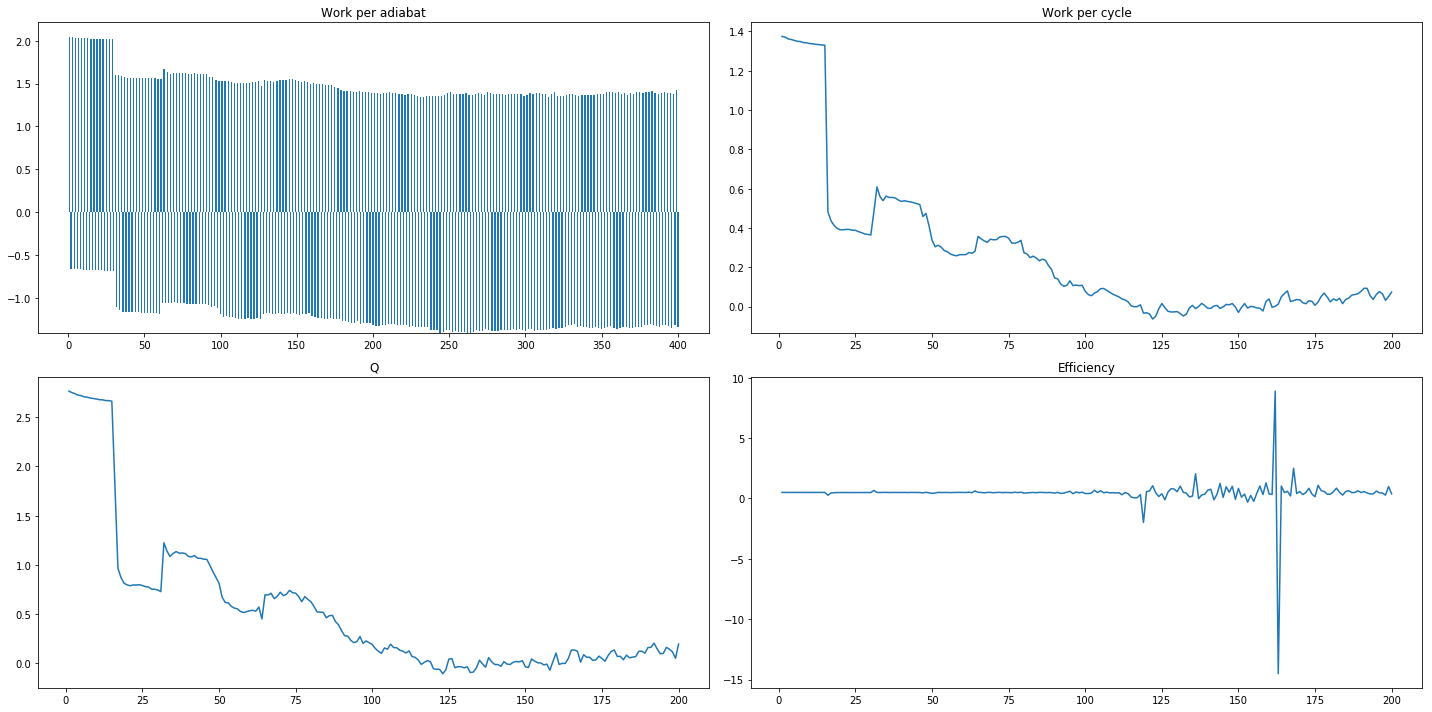

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
x  = list(range(1, Ncycle + 1))
xp = list(range(1, 2 * Ncycle + 1))
ax1.bar(xp, workAdiabatic)
ax1.set_title('Work per adiabat')
ax2.plot(x, workcycle)
ax2.set_title('Work per cycle')
ax3.plot(x, Q)
ax3.set_title('Q')
ax4.plot(x, efficiency)
ax4.set_title('Efficiency')

f.tight_layout()

plt.show()